<div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Escudo-UdeA.svg/1655px-Escudo-UdeA.svg.png" width="100"><br><br>

  <h1>Avances proyecto: Evaluación de la entropía cerebral de la red por defecto en el continuo de la<br>
  enfermedad de Alzheimer</h1>
  

<font  face="Times New Roman" size="3">
<p1><center> Ana C. Mejía - Isabella Vásquez - Luisa F. Taho</center></p1>
<p1><center> ana.mejiaa@udea.edu.co - isabella.vasquezg@udea.edu.co - luisataho@udea.edu.co</center></p1>
<p1><center> Bioingeniería, Facultad de Ingeniería, Universidad de Antioquia Sede Medellín</center></p1>
<p1><center> Grupo de Investigación: GRUNECO</center></p1>
<p1><center> Asesores: John Fredy Ochoa, Claudia Patricia Aponte</center></p1>

## **I. DMN extraction**

### **Open libraries and import resources**


In [435]:
#Neuroimaging libraries

!pip install nilearn
!pip install heatmapz
!pip install nitime

In [436]:
# Files
import os
import shutil

# Scientific computation and data analysis
import numpy as np
import pandas as pd
from scipy.io import loadmat
import scipy.stats.distributions as dist
from scipy import fftpack
import math
from numpy import savetxt
import itertools
import csv
import glob #Importing files with an specific pattern in their labels
from scipy.spatial.distance import euclidean

# Plot libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heatmap import heatmap, corrplot
from nilearn import plotting
import seaborn as sns

# Neuroimaging libraries
import nibabel as nib
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.input_data import NiftiSpheresMasker
from nilearn.maskers import NiftiLabelsMasker

#Time series in Neuroscience
import nitime
from nitime.timeseries import TimeSeries
from nitime import utils
import nitime.algorithms as alg
import nitime.viz
from nitime.viz import drawmatrix_channels
from nitime.analysis import CoherenceAnalyzer, MTCoherenceAnalyzer

# **Adding files**

In [440]:
#Selecting the data (path)

path_subjects_aC = 'aC/FunImgARglobalCWF/'
subjects_aC = [path_subjects_aC + i for i in os.listdir(path_subjects_aC)]

#path_subjectsCtrl = '/content/drive/Shareddrives/neuroimagen_avanzada/Taller_Brain_Connectivity_fMRI/Imágenes AD - CN originales/Control/FunImgARglobalCWF/'
#subjects_Ctrl = [path_subjectsCtrl + i for i in os.listdir(path_subjectsCtrl)]

#This works if all the previously preprocessed data is inside a single folder
#If there is needed to only use some objects from a certain folder, the function glob can be used

In [442]:
#Verificamos la longitud para asegurarnos de que están todos los sujetos
len(subjects_aC)

33

Adding the code/name for files from matrices

In [445]:
#List with the name of subjects for row names in dataframe

#Take into consideration that this code needs to be remade with BIDS standard

names_subjects_aC = [] #Void list 

for i in os.listdir(path_subjects_aC):
  names_subjects_aC.append(i)
    
print(names_subjects_aC)

#names_subjectsCtrl = []
#for i in os.listdir(path_subjectsCtrl):
#  subj = path_subjectsCtrl+i
#  name_subject = subj.split("/")[-1].split(".")[0].replace("dswau", "") #This last line has to be changed according to the name of the files, this can be standarized with BIDS
#  names_subjectsCtrl.append(name_subject + "/Filtered_4DVolume.nii")

#print(names_subjectsCtrl)

['SAN_001.nii', 'SAN_004.nii', 'SAN_008.nii', 'SAN_015.nii', 'SAN_021.nii', 'SAN_024.nii', 'SAN_030.nii', 'SAN_034.nii', 'SAN_052.nii', 'SAN_055.nii', 'SAN_060.nii', 'SAN_065.nii', 'SAN_066.nii', 'SAN_067.nii', 'SAN_067_86.nii', 'SAN_069.nii', 'SAN_070.nii', 'SAN_071.nii', 'SAN_080.nii', 'SAN_083.nii', 'SAN_086.nii', 'SAN_087.nii', 'SAN_090.nii', 'SAN_092.nii', 'SAN_094.nii', 'SAN_096.nii', 'SAN_097.nii', 'SAN_099.nii', 'SAN_101.nii', 'SAN_104.nii', 'SAN_105.nii', 'SAN_106.nii', 'SAN_107.nii']


In [447]:
len(names_subjects_aC)

33

https://www.researchgate.net/publication/356246115_Dataset_of_functional_connectivity_during_cognitive_control_for_an_adult_lifespan_sample

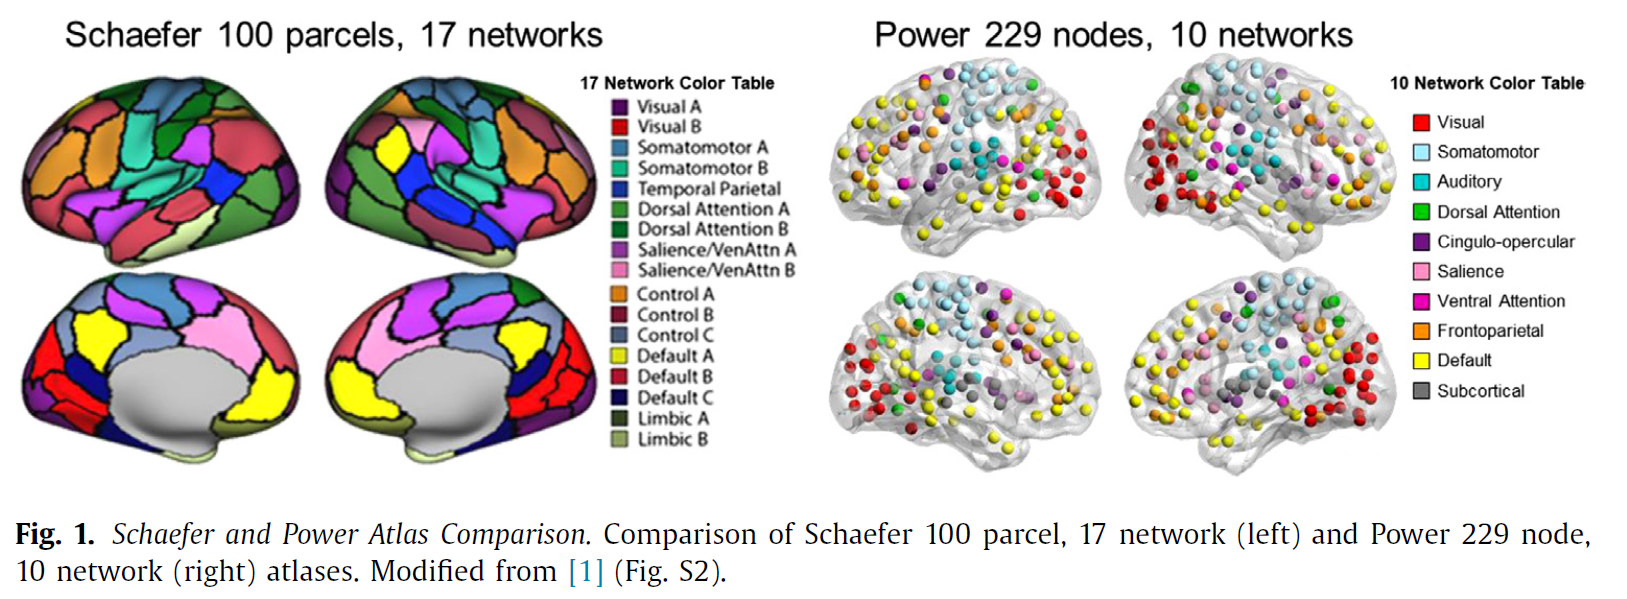

In [450]:
# Loading Schaefer 400 Atlas.
schaefer_atlas_400_17 = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1)
atlas_img = schaefer_atlas_400_17['maps']

[get_dataset_dir] Dataset found in C:\Users\USUARIO\nilearn_data\schaefer_2018

In [452]:
#Creating the Mask
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True, verbose=5)
masker.fit()

[NiftiLabelsMasker.fit] loading data from 
C:\Users\USUARIO\nilearn_data\schaefer_2018\Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz

NiftiLabelsMasker(labels_img='C:\\Users\\USUARIO\\nilearn_data\\schaefer_2018\\Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz',
                  memory=Memory(location=None), standardize=True, verbose=5)

In [453]:
#DMN indices and regions extraction
dmn_shaefern = [
    i for i, label in enumerate(schaefer_atlas_400_17['labels'])
    if 'Default' in label.decode('utf-8')
]
print(f"Índices de DMN: {dmn_shaefern}")
print(f"Número de regiones DMN: {len(dmn_shaefern)}")

#Out array
timepoints = 264  # Cambia si tus señales tienen diferente número de puntos
n_subjects = len(names_subjects_aC)
n_dmn_regions = len(dmn_shaefern)

subjects_shaefern17r400 = np.zeros((n_subjects, timepoints, n_dmn_regions))

# BOLD Signals extraction
subject = 0
for i, name in enumerate(names_subjects_aC):
    file_path = path_subjects_aC + name
    print(f"Procesando {file_path}")

    try:
        data = masker.transform(file_path)  # (timepoints, 400 regiones)

        if data.ndim == 2 and data.shape[1] >= max(dmn_shaefern):
            subjects_shaefern17r400[subject, :, :] = data[:, dmn_shaefern]
            subject += 1
        else:
            print(f"El archivo {name} tiene forma inesperada: {data.shape}")
    except:
        print(f"Error procesando {file_path}: {e}")

Índices de DMN: [148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389]
Número de regiones DMN: 79
Procesando aC/FunImgARglobalCWF/SAN_001.nii


[NiftiLabelsMasker.wrapped] Resampling labels

[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_001.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_004.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_004.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_008.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_008.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_015.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_015.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_021.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_021.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_024.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_024.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_030.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_030.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_034.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_034.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_052.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_052.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_055.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_055.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_060.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_060.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_065.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_065.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_066.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_066.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_067.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_067.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_067_86.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_067_86.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_069.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_069.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_070.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_070.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_071.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_071.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

C:\Users\USUARIO\Documents\CAROLINA\Lib\site-packages\nilearn\regions\signal_extraction.py:332: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(imgs, ensure_finite=True)


[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_080.nii


C:\Users\USUARIO\Documents\CAROLINA\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_080.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_083.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_083.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_086.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_086.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_087.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_087.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_090.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_090.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_092.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_092.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_094.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_094.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_096.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_096.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_097.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_097.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_099.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_099.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_101.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_101.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_104.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_104.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_105.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_105.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_106.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_106.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

Procesando aC/FunImgARglobalCWF/SAN_107.nii


[NiftiLabelsMasker.wrapped] Loading data from aC\FunImgARglobalCWF\SAN_107.nii

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

In [458]:
#Create the list with subject's id for the dataframe
subjects=[]
for i in names_subjects_aC:
    name = i.replace('.nii', '')
    subjects.append(name)

In [460]:
print(subjects_shaefern17r400.shape) #33 subjects, 264 time points, 79 regions.

(33, 264, 79)


In [462]:
signal_0 = subjects_shaefern17r400[0, :, 0] #Example

In [464]:
len(signal_0)

264

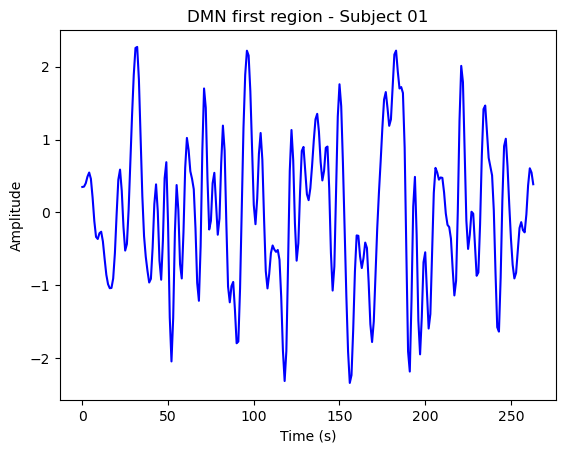

In [466]:
plt.plot(signal_0, color='b')
plt.title(f"DMN first region - Subject 01")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [468]:
print(type(subjects_shaefern17r400[subj, :, reg]))
print(subjects_shaefern17r400[0, :, 0].shape)

<class 'numpy.ndarray'>
(264,)


**DataFrame with subject's DMN signal**

In [471]:
n_sujetos = subjects_shaefern17r400.shape[0]
n_regiones = subjects_shaefern17r400.shape[2]

region_names = [schaefer_atlas_400_17['labels'][i].decode('utf-8') for i in dmn_shaefern]

df_signals = pd.DataFrame(index=subjects, columns=region_names)

for subj, subj_name in enumerate(subjects):
    for reg, reg_name in enumerate(region_names):
        df_signals.loc[subj_name, reg_name] = subjects_shaefern17r400[subj, :, reg]

In [473]:
df_signals.to_excel('aC_DMN_signals.xlsx')

## II. **Permutation entropy extraction**

In [476]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and
its different variations.'''

def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    time_series = ts
    possible_permutations = list(itertools.permutations(range(embdim)))
    lst = list()
    for i in range(len(time_series) - embdelay * (embdim - 1)):
        sorted_index_array = list(np.argsort(time_series[i:(embdim+i)]))
        lst.append(sorted_index_array)
    lst = np.array(lst)
    element, freq = np.unique(lst, return_counts = True, axis = 0)
    freq = list(freq)
    if len(freq) != len(possible_permutations):
        for i in range(len(possible_permutations)-len(freq)):
            freq.append(0)
        return(freq)
    else:
        return(freq)

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

In [656]:
entropy_rows = []

for subject_id in df_signals.index:  
    row_data = {'Subject': subject_id,
               'Group': 'aC'}
    
    for region in df_signals.columns:  
        ts = df_signals.loc[subject_id, region]
        ordinal_pat_freq = ordinal_patterns(ts, embdim=3, embdelay=1)  
        pe = p_entropy(ordinal_pat_freq)
        row_data['PE_' + region] = pe
    
    entropy_rows.append(row_data)

entropy_aC = pd.DataFrame(entropy_rows)
entropy_aC.to_excel('aC_entropy.xlsx')

In [658]:
entropy_nC = pd.read_excel('nC_entropy.xlsx')
entropy_nC['Group'] = 'nC'
entropy_nC = entropy_nC.drop('Unnamed: 0', axis=1)

In [660]:
entropy = pd.concat([entropy_aC, entropy_nC]).reset_index(drop=True)  
regions = ['Subject', 'Group']
for i in entropy.columns[2:81]:
    name_region = i.replace(f'PE_17Networks_','')
    regions.append(name_region)

In [662]:
entropy.columns = regions

Al visualizar el DataFrame obtenido con los valores de entropía por permutaciones para los sujetos, se observó que el sujeto SAN_071 arrojó valores de entropía iguales a 0 en todas las regiones de la DMN, por lo que se decidió no incluirlo en el análisis comparativo. Asimismo, el sujeto SAN_067 se encontraba repetido, por lo que se descartó uno de ellos. 

In [665]:
entropy = entropy.drop(17).drop(14)

# III. **aC and nC comparison (descriptive statistics)**

### *Alzheimer's Carriers: Statistical summary*

In [669]:
entropy[entropy["Group"] == "aC"].describe()

LH_DefaultA_IPL_1  LH_DefaultA_IPL_2  LH_DefaultA_PFCd_1  \
count          31.000000          31.000000           31.000000   
mean            0.814880           0.815392            0.821353   
std             0.017094           0.019028            0.019812   
min             0.782899           0.762333            0.782887   
25%             0.802139           0.808539            0.808816   
50%             0.811290           0.813458            0.825826   
75%             0.828638           0.827970            0.837375   
max             0.853794           0.846982            0.860804   

       LH_DefaultA_PFCd_2  LH_DefaultA_PFCd_3  LH_DefaultA_pCunPCC_1  \
count           31.000000           31.000000              31.000000   
mean             0.818975            0.817473               0.813959   
std              0.015192            0.021320               0.021803   
min              0.786271            0.775233               0.766847   
25%              0.809756            0.798847               0.797772   
50%              0.820529            0.816589               0.813761   
75%              0.830814            0.837934               0.827992   
max              0.848182            0.857814               0.853374   

       LH_DefaultA_pCunPCC_2  LH_DefaultA_pCunPCC_3  LH_DefaultA_pCunPCC_4  \
count              31.000000              31.000000              31.000000   
mean                0.813725               0.820259               0.821779   
std                 0.019904               0.020438               0.019735   
min                 0.776180               0.762467               0.780686   
25%                 0.801579               0.810581               0.812255   
50%                 0.812379               0.823360               0.824178   
75%                 0.827043               0.832361               0.835073   
max                 0.851196               0.859600               0.858746   

       LH_DefaultA_pCunPCC_5  ...  RH_DefaultB_PFCd_5  RH_DefaultB_PFCv_1  \
count              31.000000  ...           31.000000           31.000000   
mean                0.831644  ...            0.824131            0.834130   
std                 0.015555  ...            0.017663            0.016416   
min                 0.786205  ...            0.784908            0.793305   
25%                 0.822124  ...            0.813794            0.825421   
50%                 0.833636  ...            0.822618            0.832093   
75%                 0.843741  ...            0.832623            0.845300   
max                 0.863667  ...            0.865925            0.865848   

       RH_DefaultB_PFCv_2  RH_DefaultB_PFCv_3  RH_DefaultC_IPL_1  \
count           31.000000           31.000000          31.000000   
mean             0.821697            0.824691           0.820032   
std              0.013526            0.015229           0.015470   
min              0.791017            0.794238           0.781691   
25%              0.814273            0.814664           0.811745   
50%              0.821089            0.825624           0.823457   
75%              0.832753            0.834472           0.831235   
max              0.843677            0.860110           0.843227   

       RH_DefaultC_IPL_2  RH_DefaultC_Rsp_1  RH_DefaultC_Rsp_2  \
count          31.000000          31.000000          31.000000   
mean            0.816379           0.828198           0.819837   
std             0.019065           0.020453           0.015840   
min             0.773112           0.778733           0.789351   
25%             0.807230           0.812984           0.809489   
50%             0.818113           0.833702           0.819650   
75%             0.826767           0.844707           0.831902   
max             0.854092           0.860301           0.849604   

       RH_DefaultC_PHC_1  RH_DefaultC_PHC_2  
count          31.000000          31.000000  
mean            0.831707           0.827372  
std        

### *non Carriers: Statistical summary*

In [672]:
entropy[entropy["Group"] == "nC"].describe()

LH_DefaultA_IPL_1  LH_DefaultA_IPL_2  LH_DefaultA_PFCd_1  \
count          24.000000          24.000000           24.000000   
mean            0.815333           0.814119            0.825245   
std             0.023551           0.018111            0.019046   
min             0.767204           0.770698            0.786808   
25%             0.802266           0.802335            0.812522   
50%             0.814000           0.815124            0.825901   
75%             0.830551           0.828602            0.840277   
max             0.868840           0.843386            0.862869   

       LH_DefaultA_PFCd_2  LH_DefaultA_PFCd_3  LH_DefaultA_pCunPCC_1  \
count           24.000000           24.000000              24.000000   
mean             0.814876            0.824333               0.822198   
std              0.021937            0.017903               0.019898   
min              0.769390            0.793226               0.778205   
25%              0.801973            0.810550               0.810054   
50%              0.810627            0.823457               0.821235   
75%              0.831109            0.836393               0.836386   
max              0.857169            0.867436               0.862953   

       LH_DefaultA_pCunPCC_2  LH_DefaultA_pCunPCC_3  LH_DefaultA_pCunPCC_4  \
count              24.000000              24.000000              24.000000   
mean                0.815137               0.815209               0.824917   
std                 0.016559               0.021505               0.017139   
min                 0.786438               0.771597               0.785622   
25%                 0.801638               0.801826               0.814625   
50%                 0.815391               0.811731               0.823618   
75%                 0.822604               0.831897               0.835654   
max                 0.854616               0.855664               0.857606   

       LH_DefaultA_pCunPCC_5  ...  RH_DefaultB_PFCd_5  RH_DefaultB_PFCv_1  \
count              24.000000  ...           24.000000           24.000000   
mean                0.826473  ...            0.819929            0.827150   
std                 0.022858  ...            0.018689            0.021882   
min                 0.770534  ...            0.782138            0.779036   
25%                 0.819813  ...            0.811441            0.814465   
50%                 0.828282  ...            0.816916            0.828247   
75%                 0.838051  ...            0.831839            0.843931   
max                 0.865613  ...            0.860092            0.859989   

       RH_DefaultB_PFCv_2  RH_DefaultB_PFCv_3  RH_DefaultC_IPL_1  \
count           24.000000           24.000000          24.000000   
mean             0.820817            0.821804           0.816635   
std              0.016125            0.019099           0.016562   
min              0.794969            0.768005           0.789225   
25%              0.810301            0.812823           0.806238   
50%              0.818551            0.822964           0.816173   
75%              0.832465            0.833719           0.824105   
max              0.849215            0.852191           0.856272   

       RH_DefaultC_IPL_2  RH_DefaultC_Rsp_1  RH_DefaultC_Rsp_2  \
count          24.000000          24.000000          24.000000   
mean            0.817972           0.831326           0.816927   
std             0.021430           0.013484           0.016709   
min             0.783418           0.802513           0.789812   
25%             0.802800           0.822236           0.807396   
50%             0.815530           0.832072           0.817305   
75%             0.826984           0.838154           0.824618   
max             0.865239           0.858570           0.867203   

       RH_DefaultC_PHC_1  RH_DefaultC_PHC_2  
count          24.000000          24.000000  
mean            0.835063           0.827378  
std        

In [674]:
columnas_entropia = entropy.columns.difference(['Group', 'Subject'])

In [676]:
n_filas = 5  
n_columnas = 6  
n_por_figura = n_filas * n_columnas

n_regiones = len(columnas_entropia) 
n_sets = int(np.ceil(n_regiones / n_por_figura))

columnas_entropia = columnas_entropia.tolist() 

### *Boxplots*

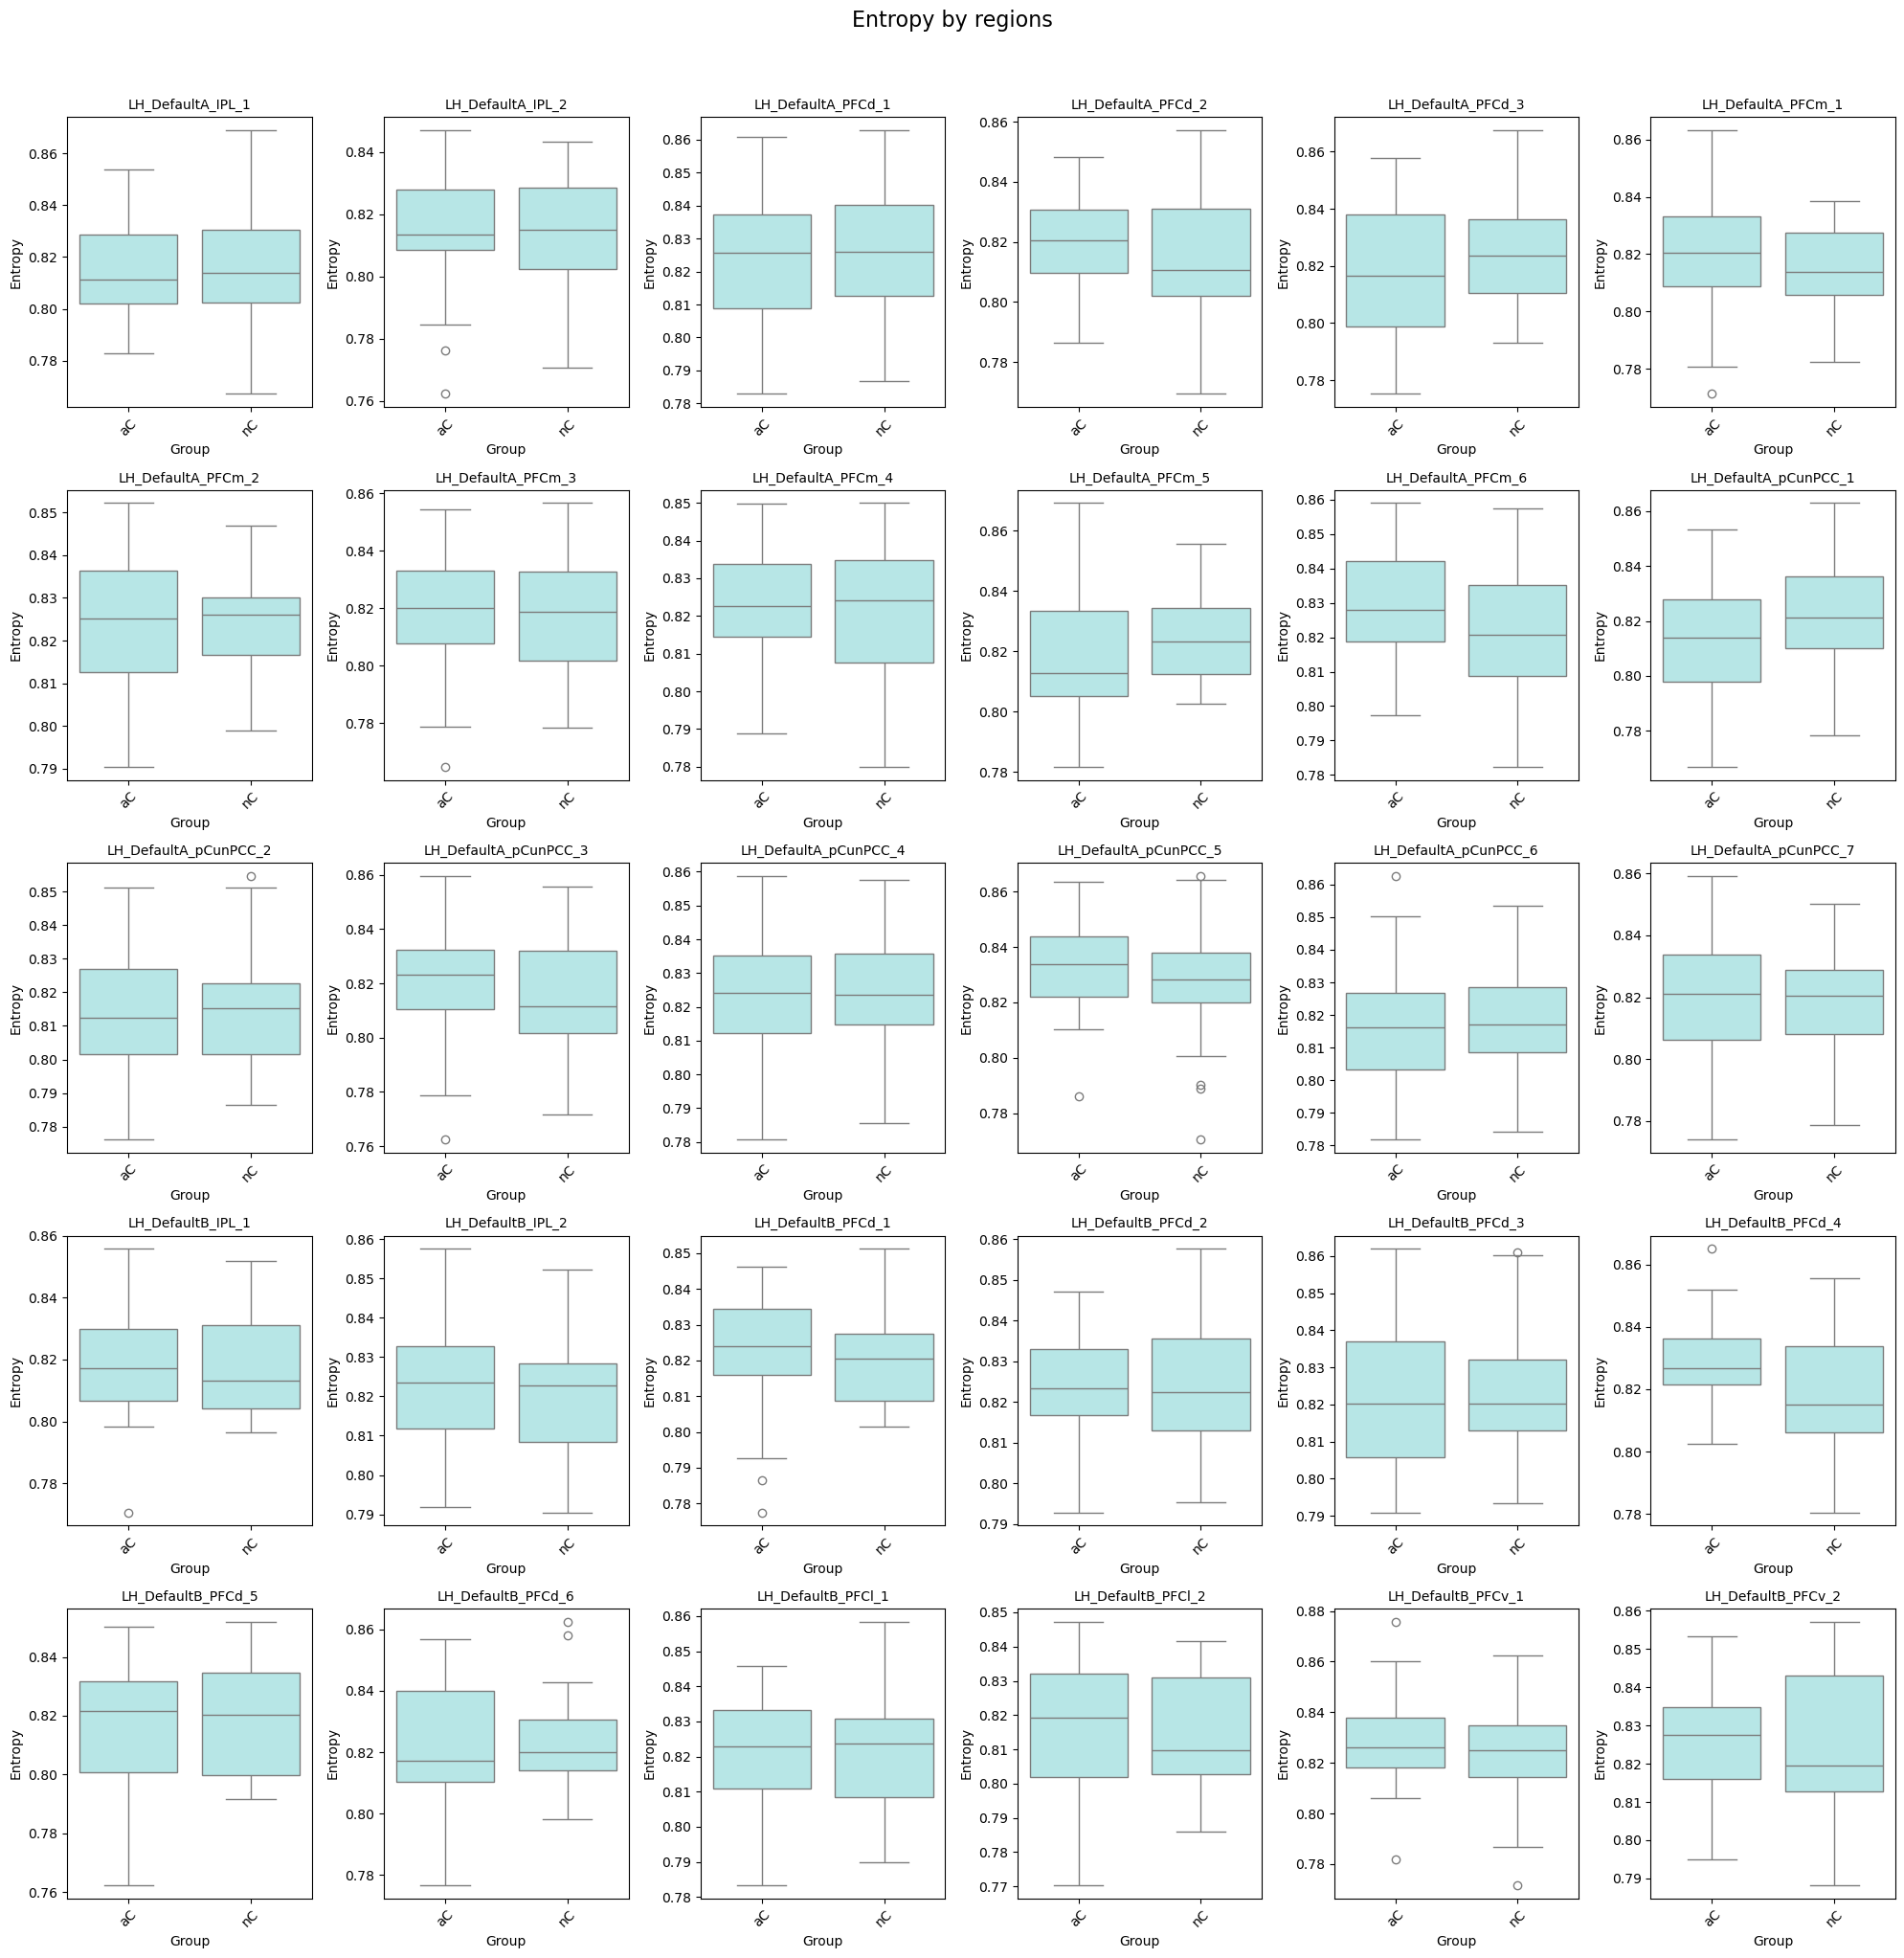

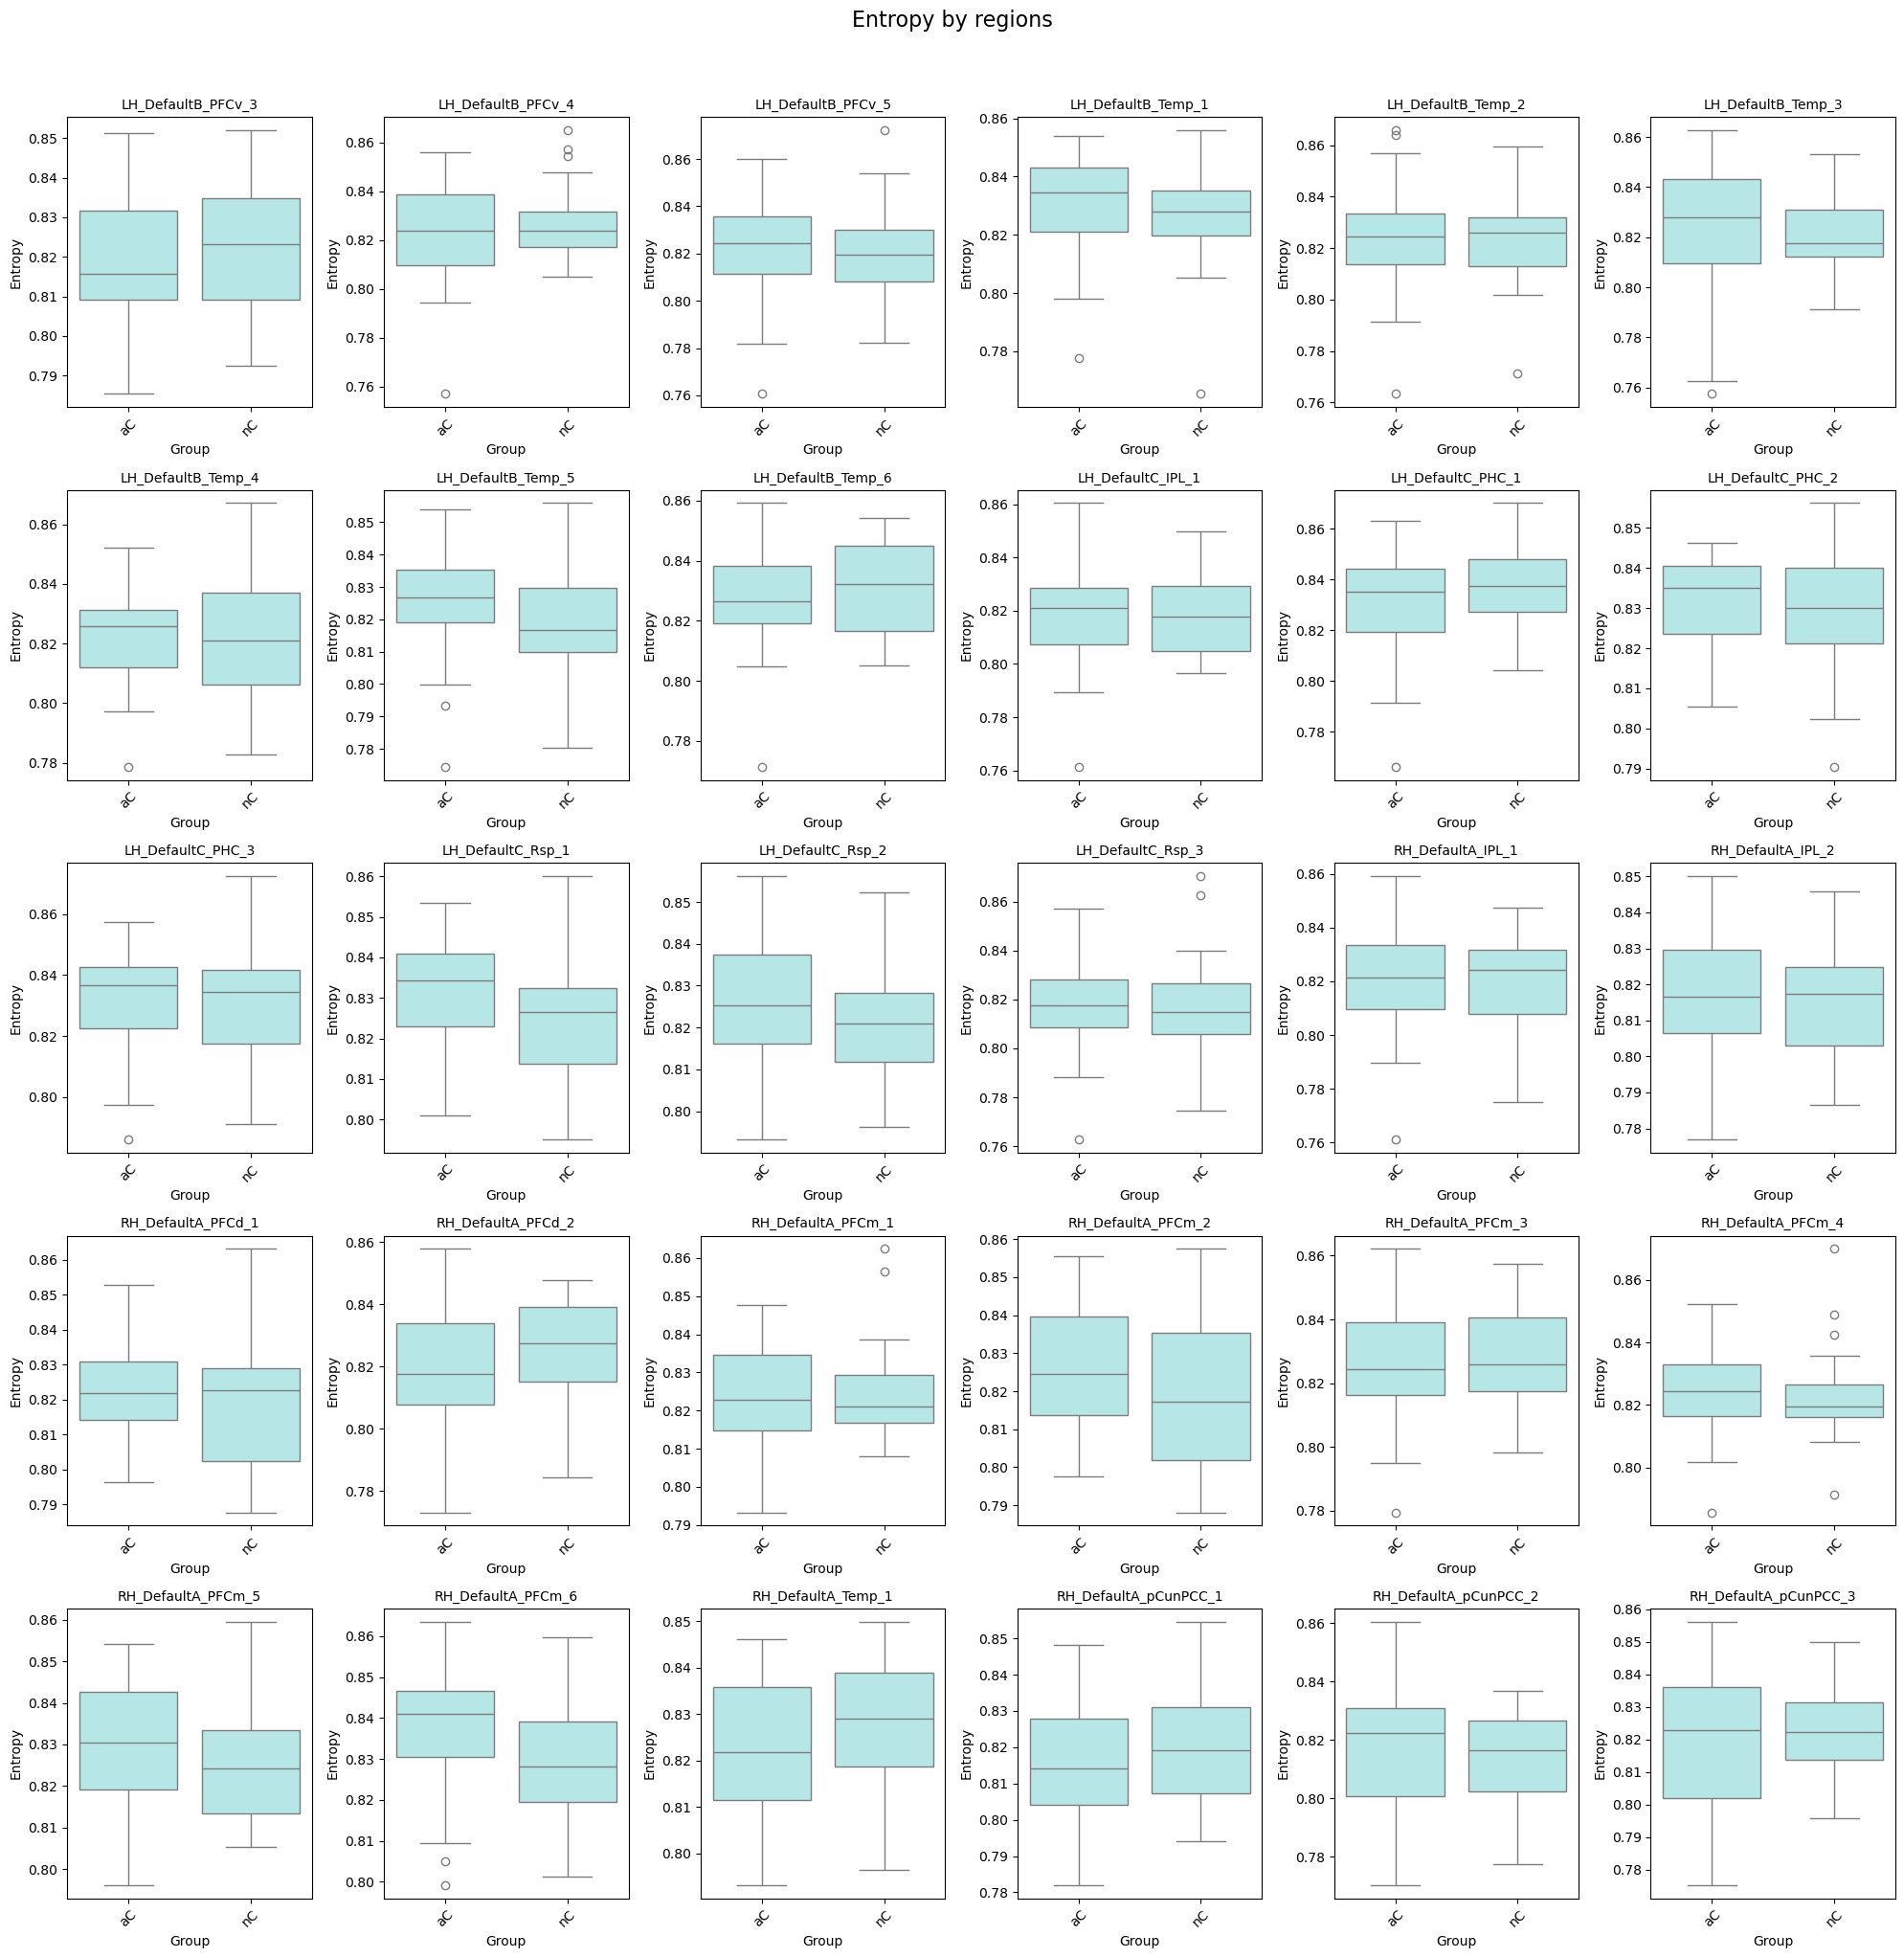

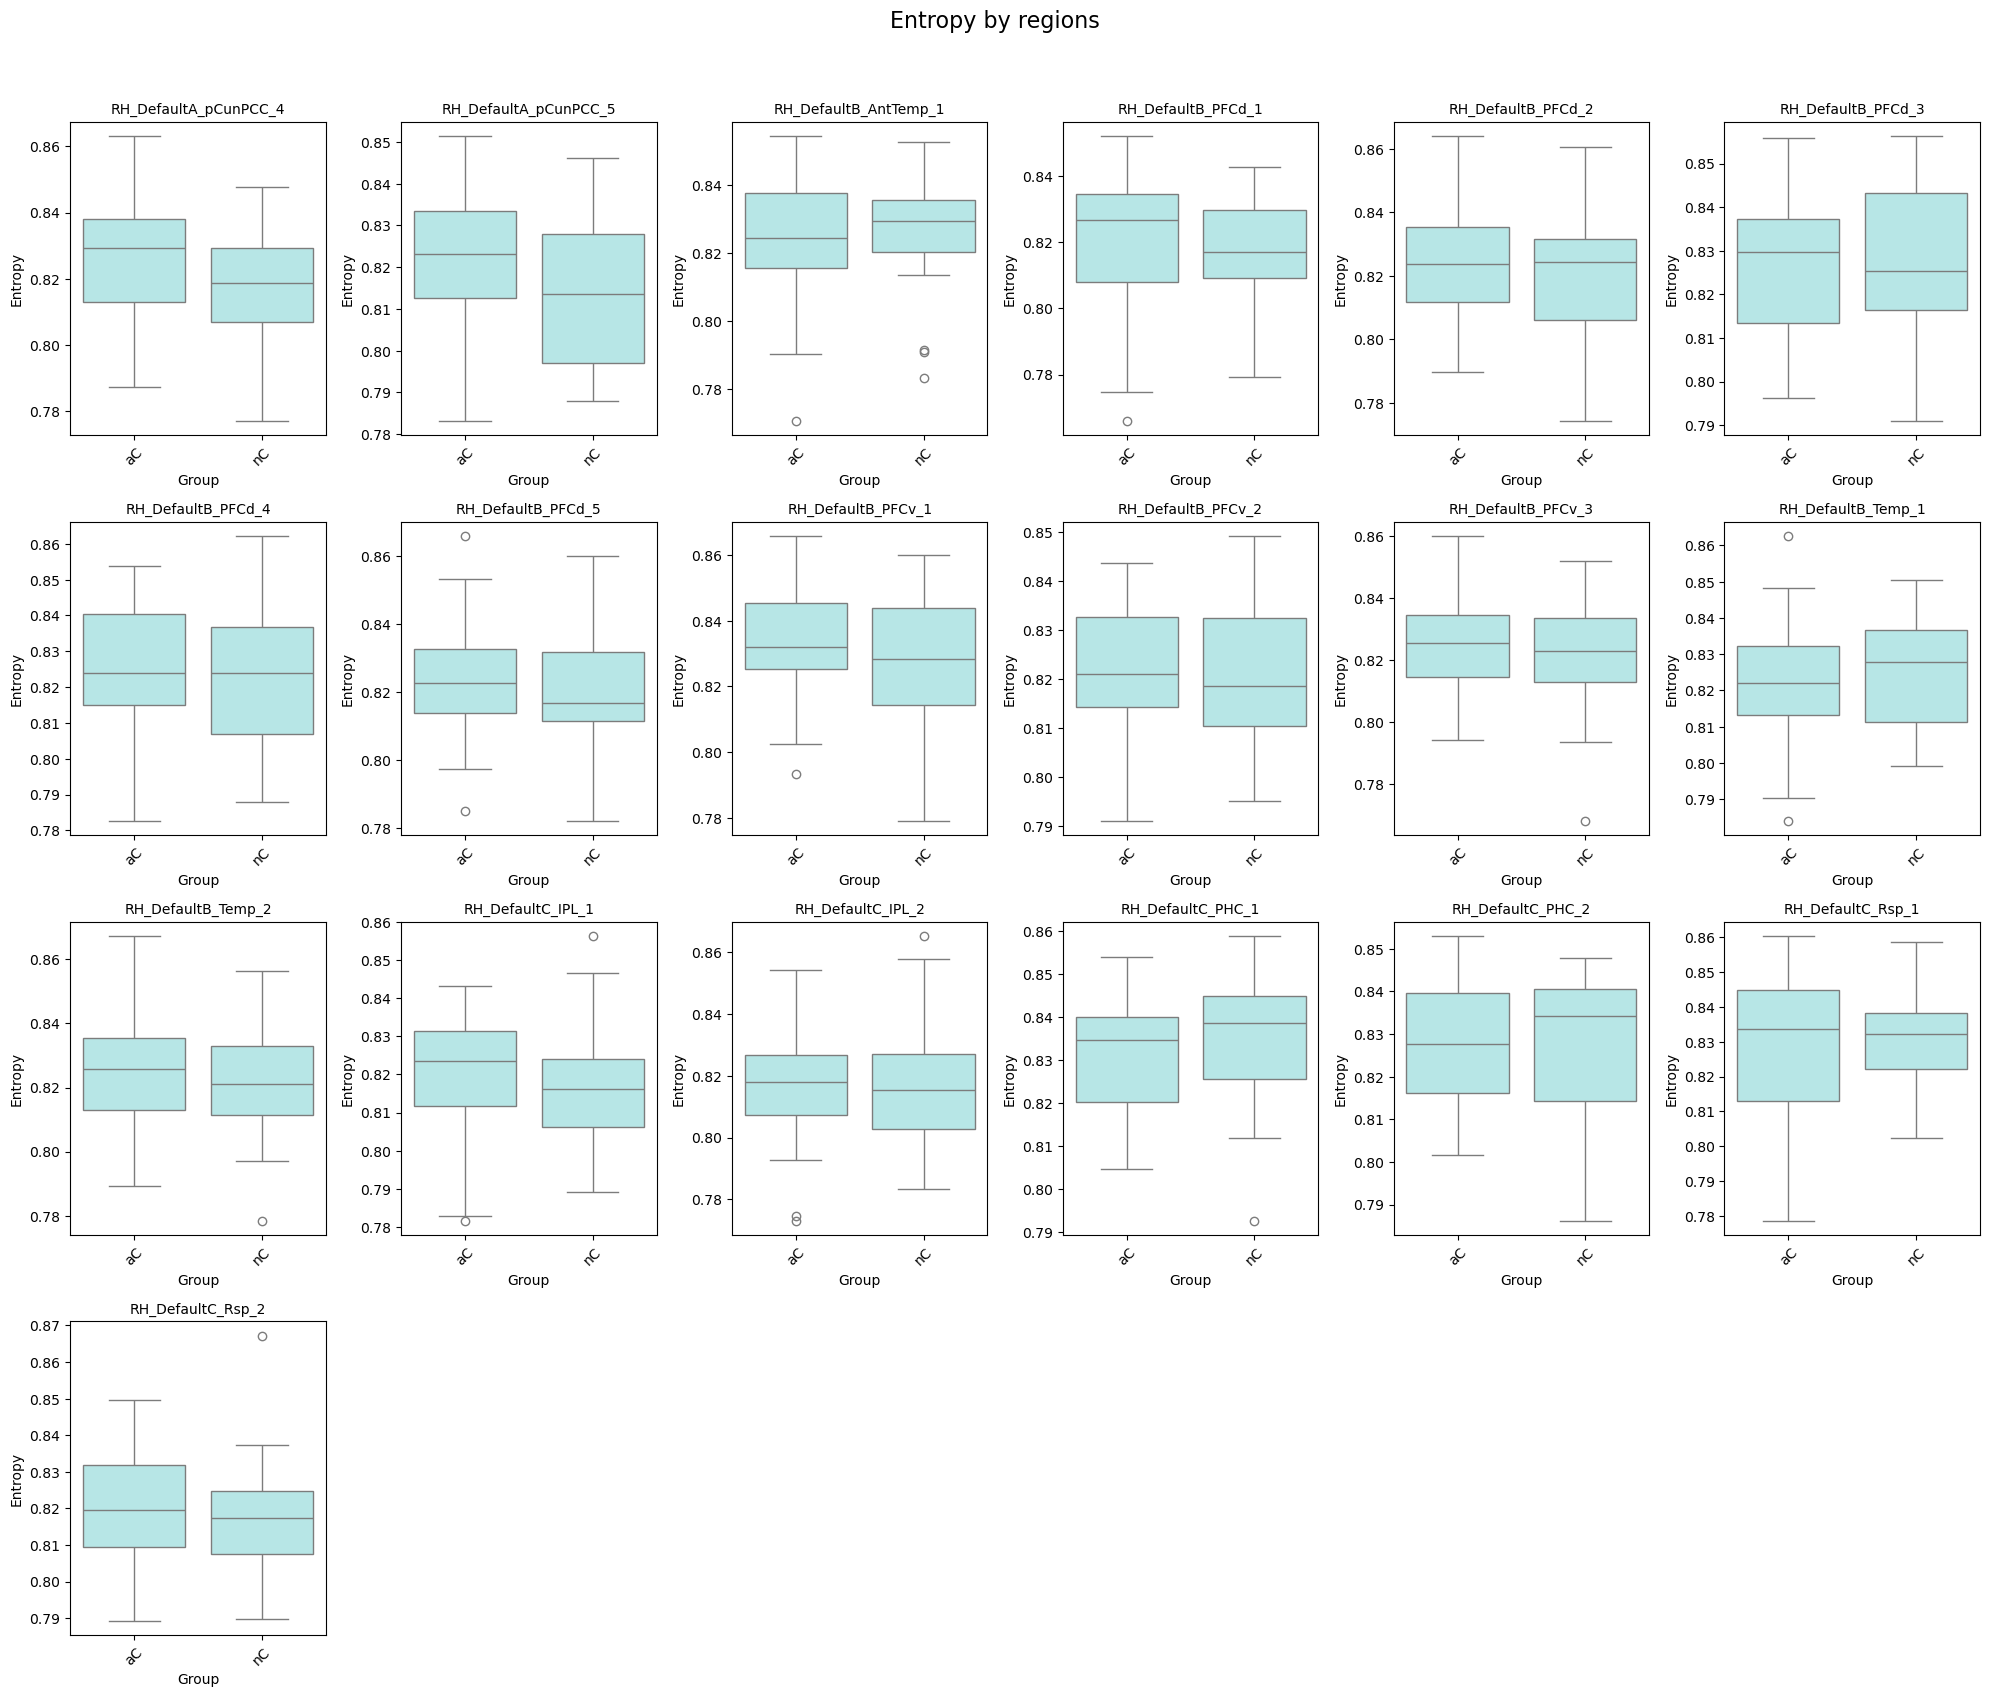

In [679]:
for set_num in range(n_sets):
    start_idx = set_num * n_por_figura
    end_idx = min((set_num + 1) * n_por_figura, n_regiones)
    regiones_set = columnas_entropia[start_idx:end_idx]
    
    fig, axes = plt.subplots(n_filas, n_columnas, figsize=(20, 4 * n_filas))
    fig.suptitle(f"Entropy by regions", fontsize=16, y=1.02)
    axes = axes.flatten()
    
    for i, region in enumerate(regiones_set):
        sns.boxplot(data=entropy, x="Group", y=region, ax=axes[i], color = 'paleturquoise')
        axes[i].set_title(region, fontsize=10)
        axes[i].set_ylabel("Entropy") 
        axes[i].tick_params(axis='x', rotation=45)
    
    for j in range(len(regiones_set), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()

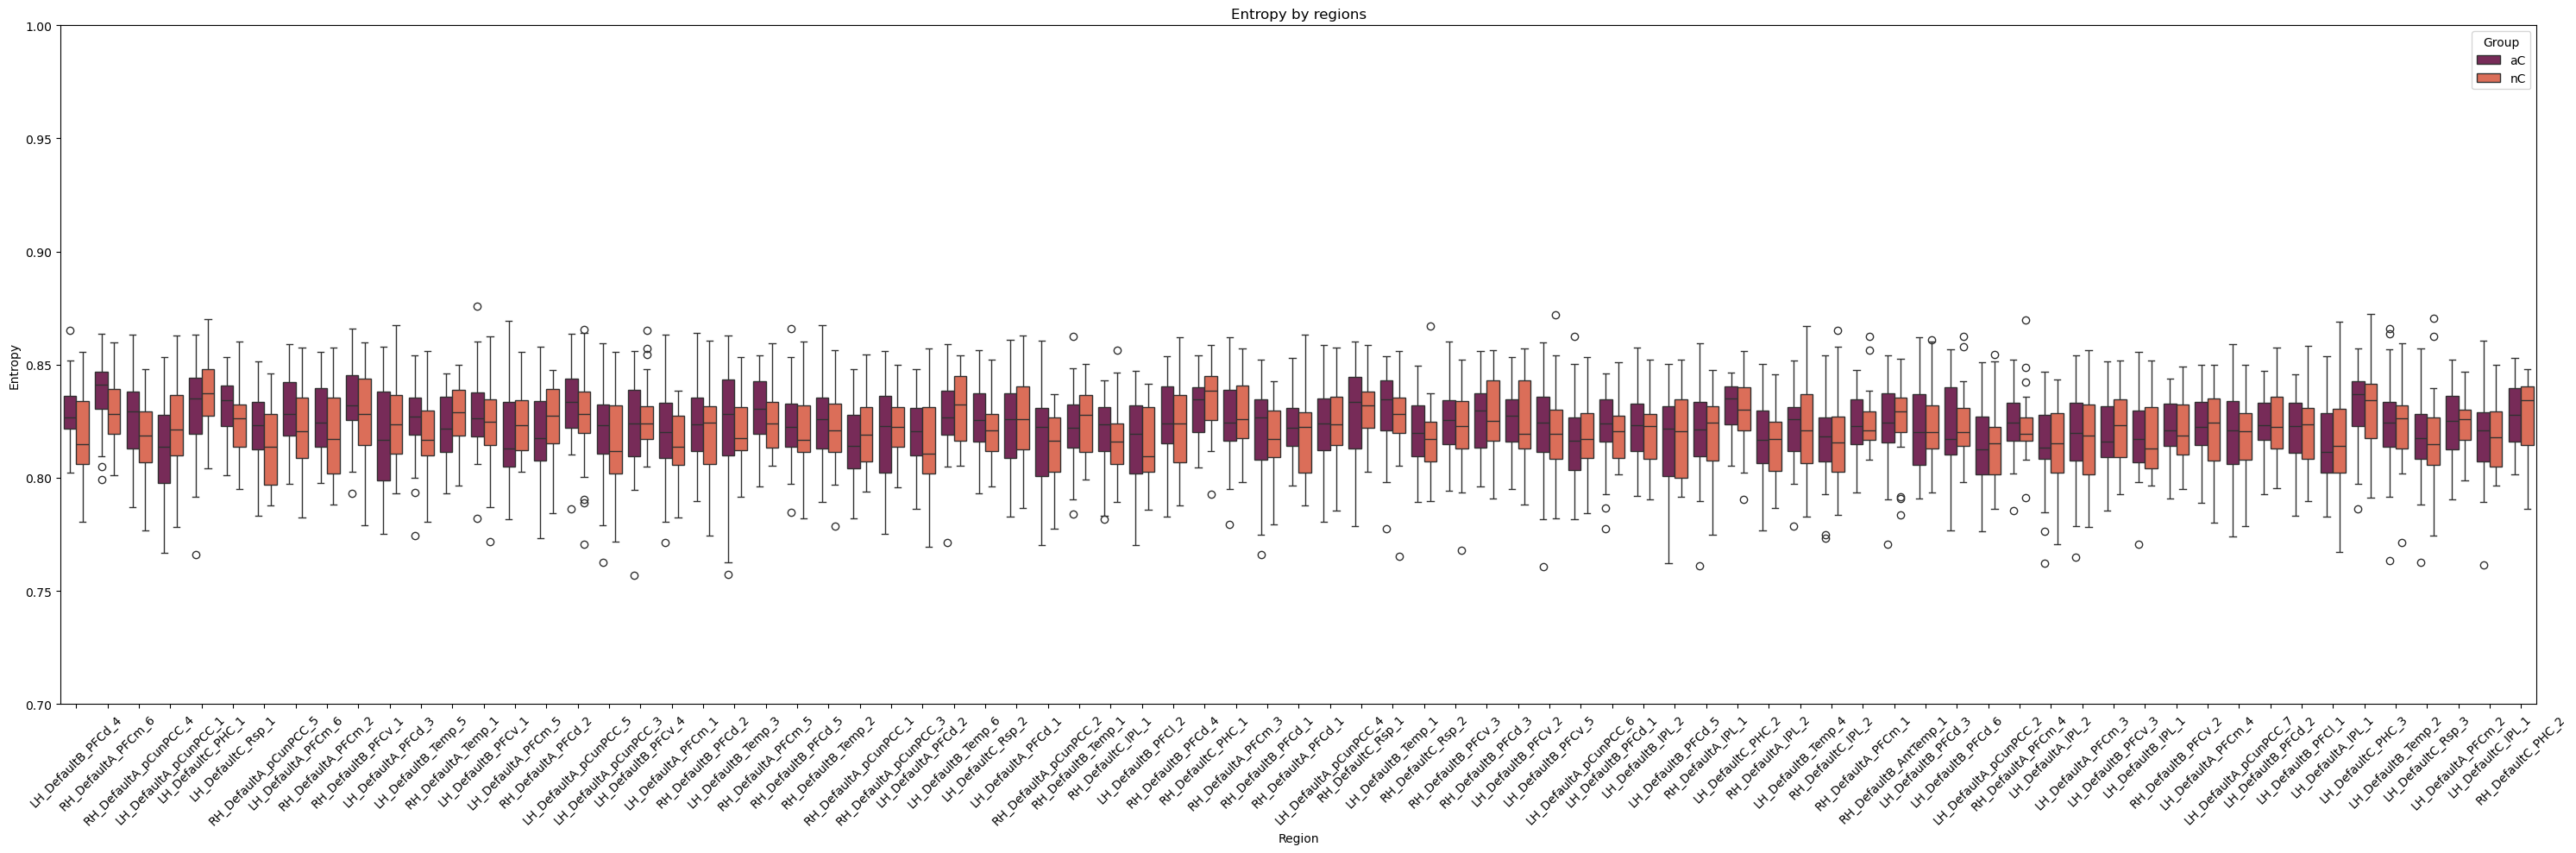

In [683]:
diferencias = entropy.groupby("Group")[columnas_entropia].mean().diff().iloc[-1].abs()
top_regiones = diferencias.sort_values(ascending=False).head(79).index
entropy_melt = entropy.melt(id_vars=["Group"], value_vars=top_regiones,
                            var_name="Region", value_name="Entropy")

plt.figure(figsize=(30, 10))
sns.boxplot(data=entropy_melt, x="Region", y="Entropy", hue="Group", palette = 'rocket')
plt.xticks(rotation=45)
plt.title("Entropy by regions")
plt.ylabel("Entropy")
plt.ylim(0.7,1)
plt.tight_layout()

### *Histograms*

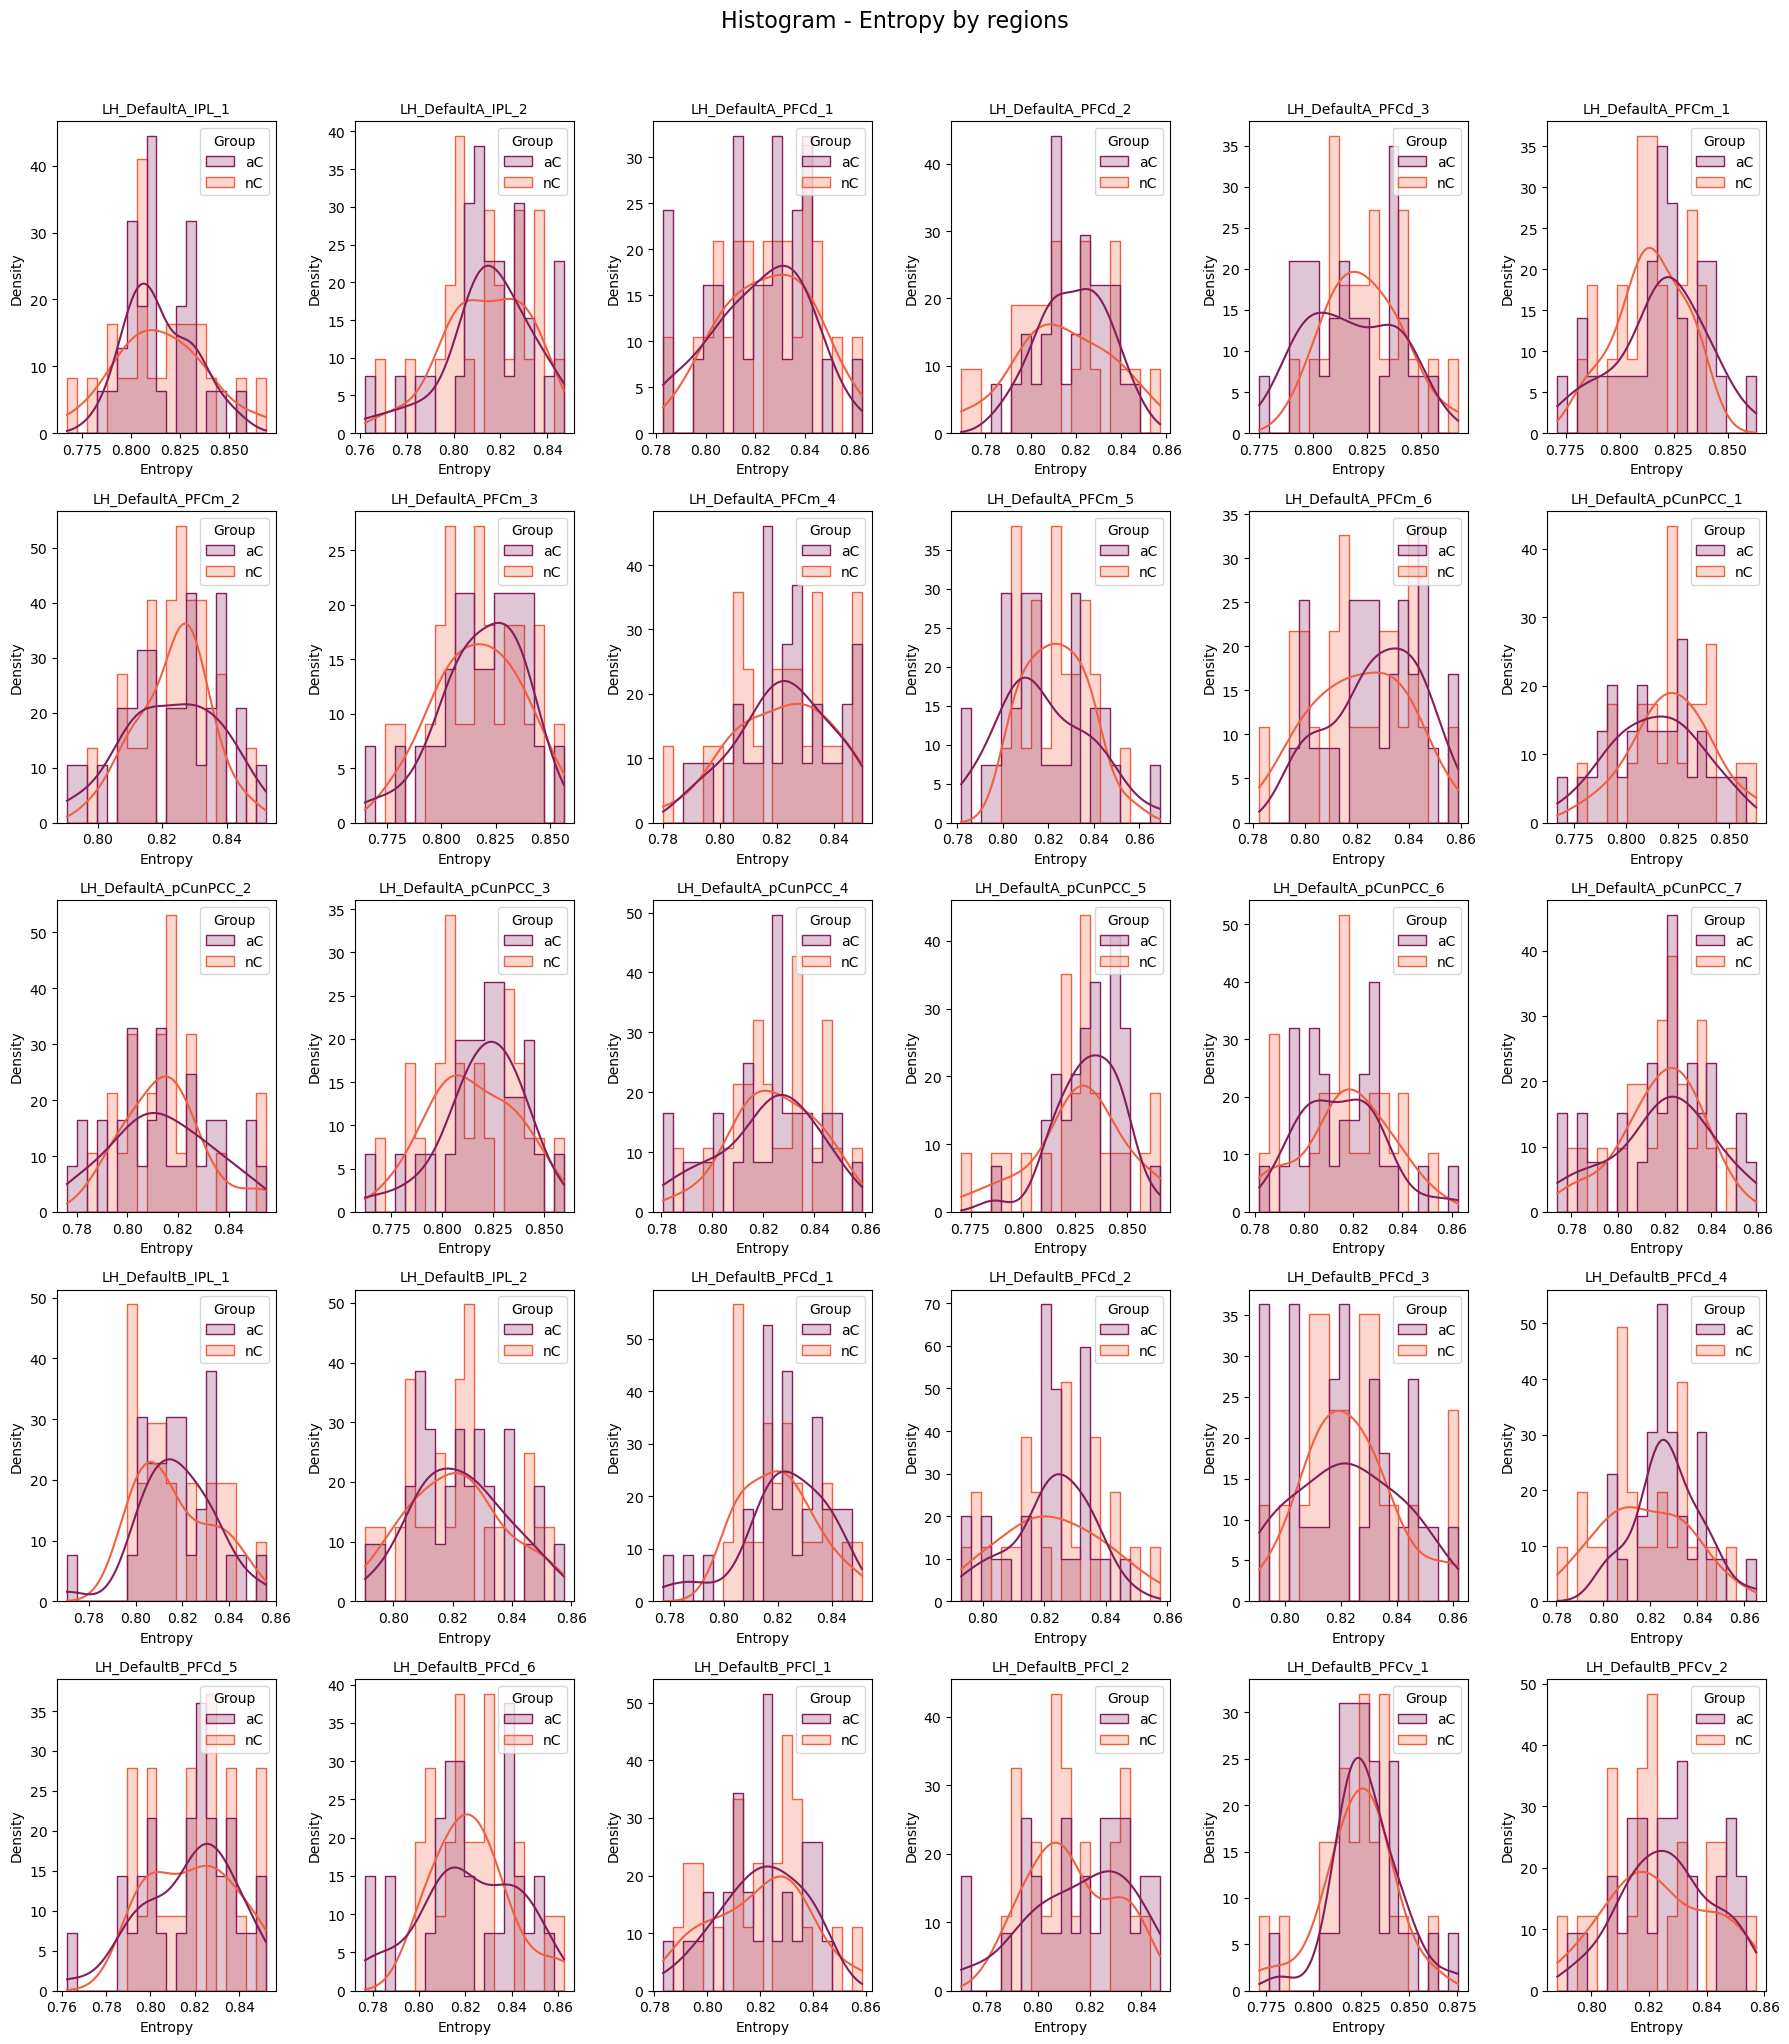

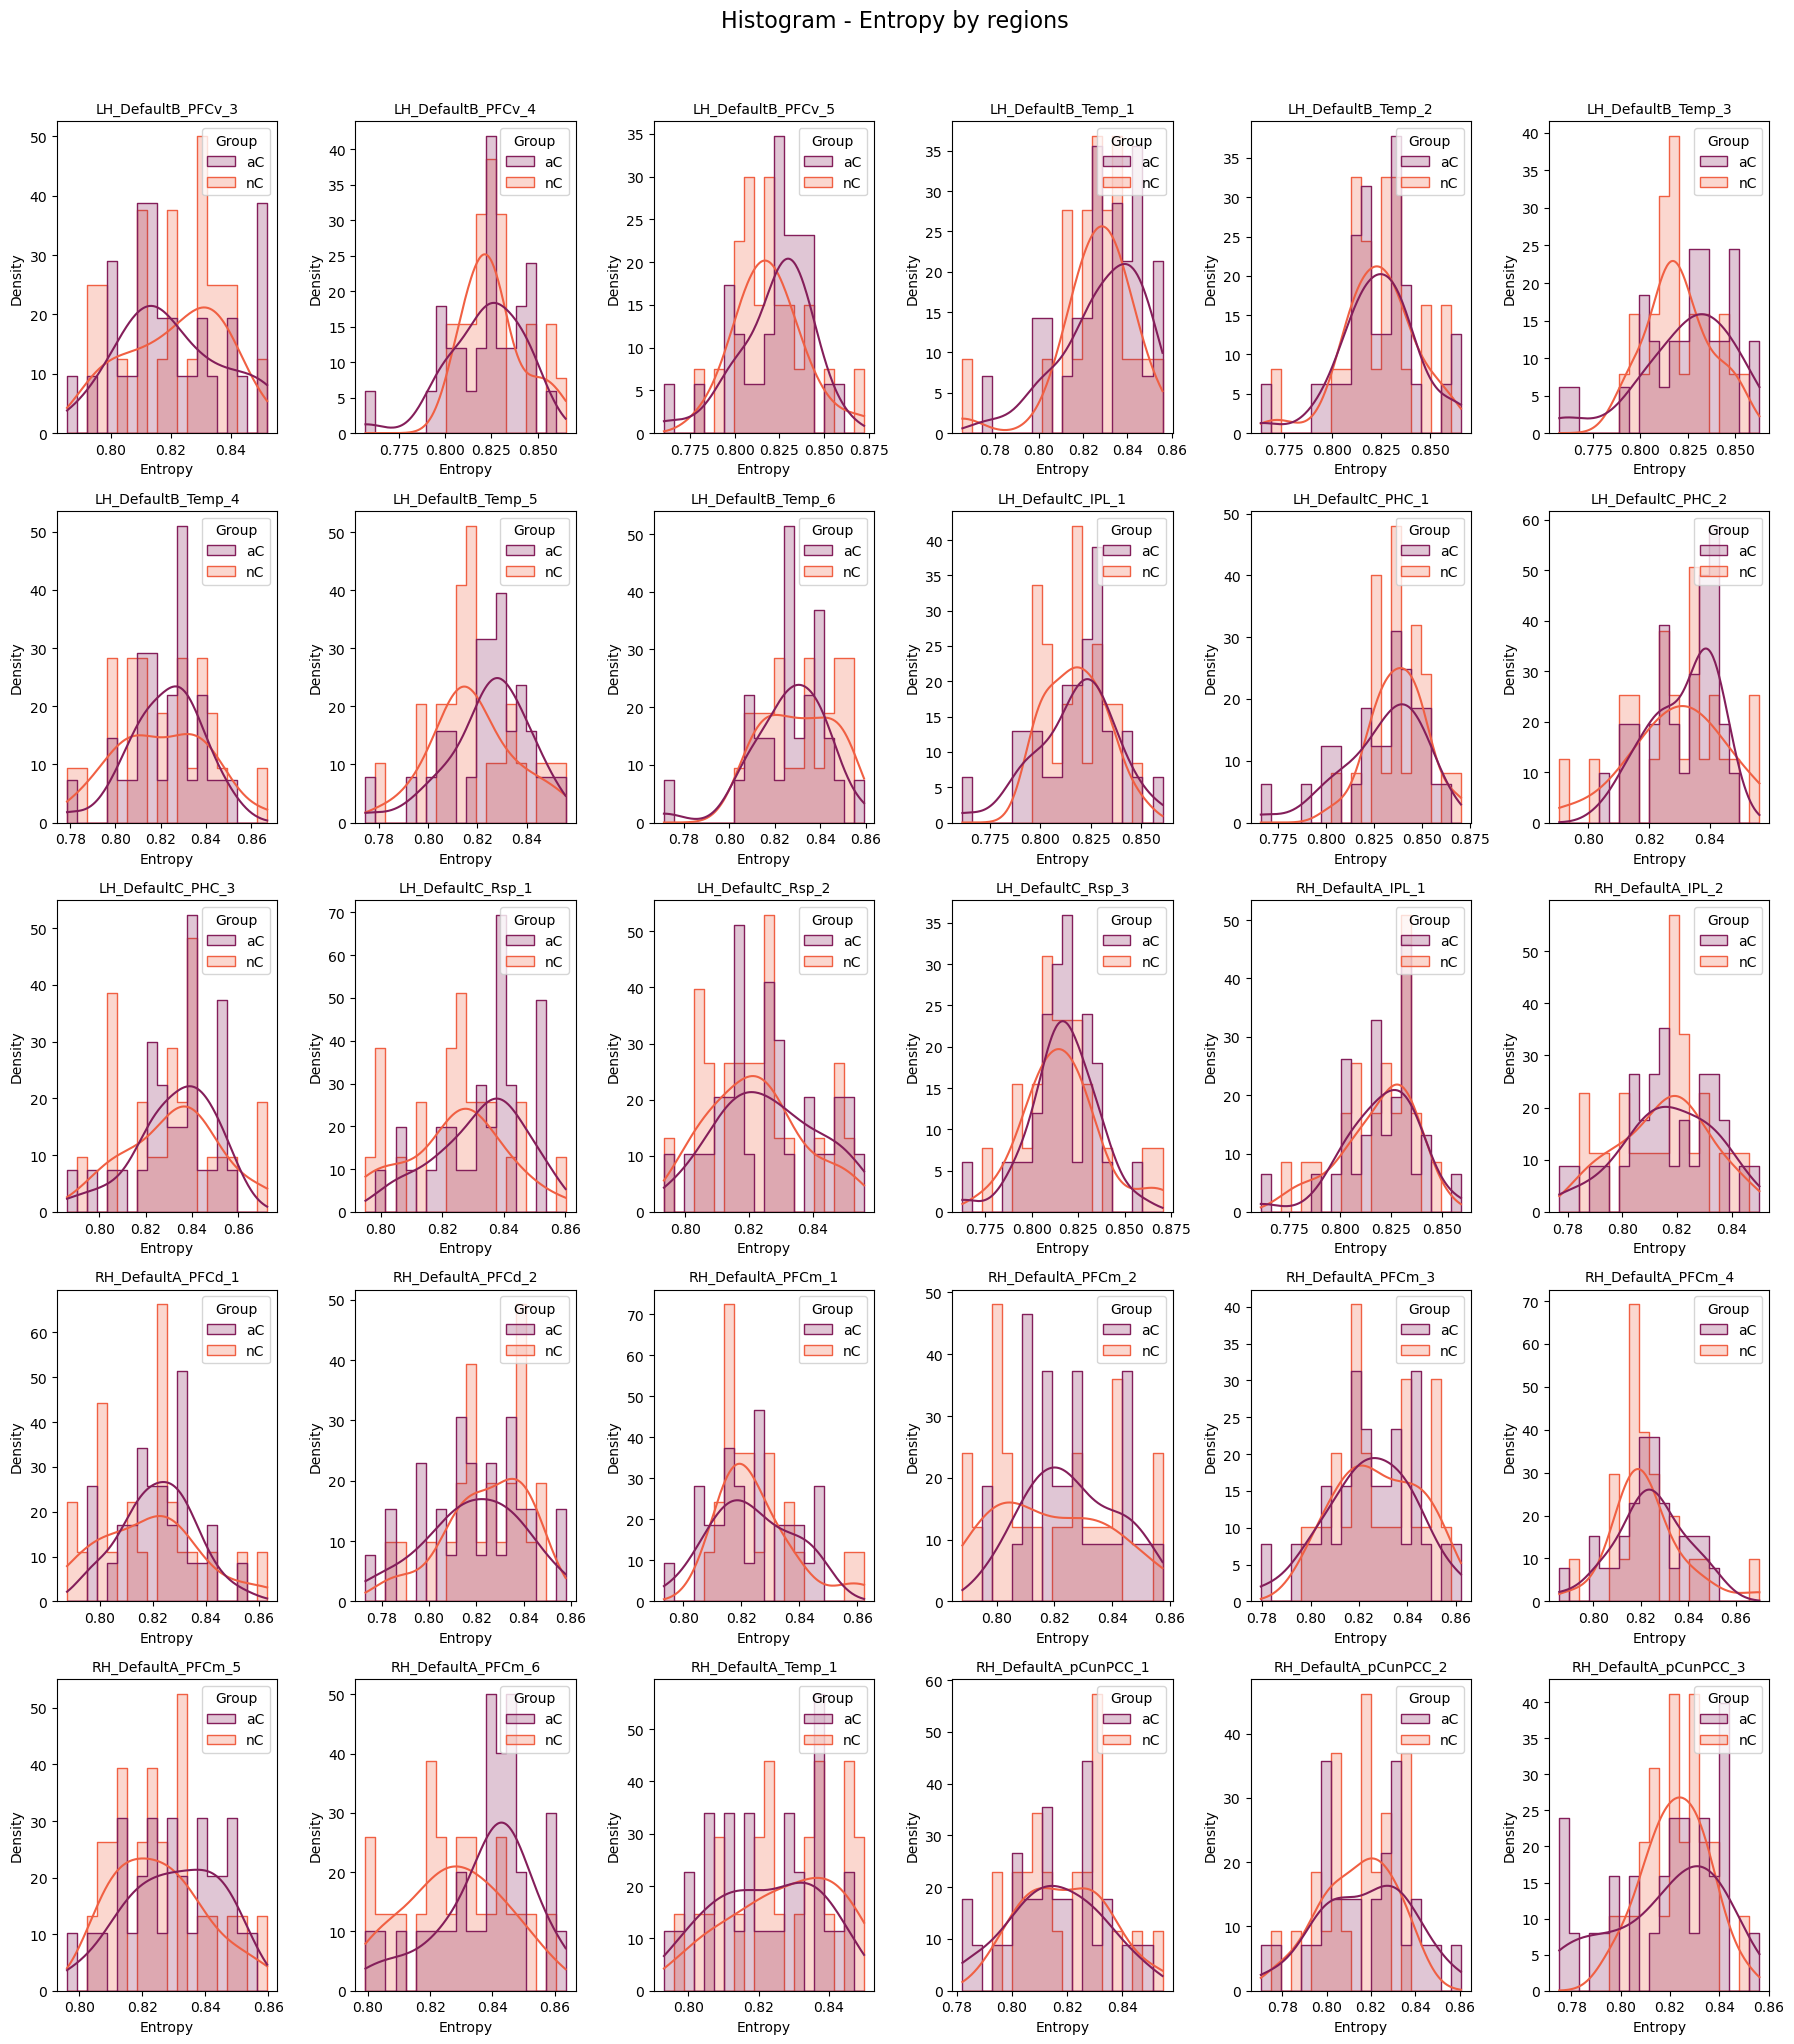

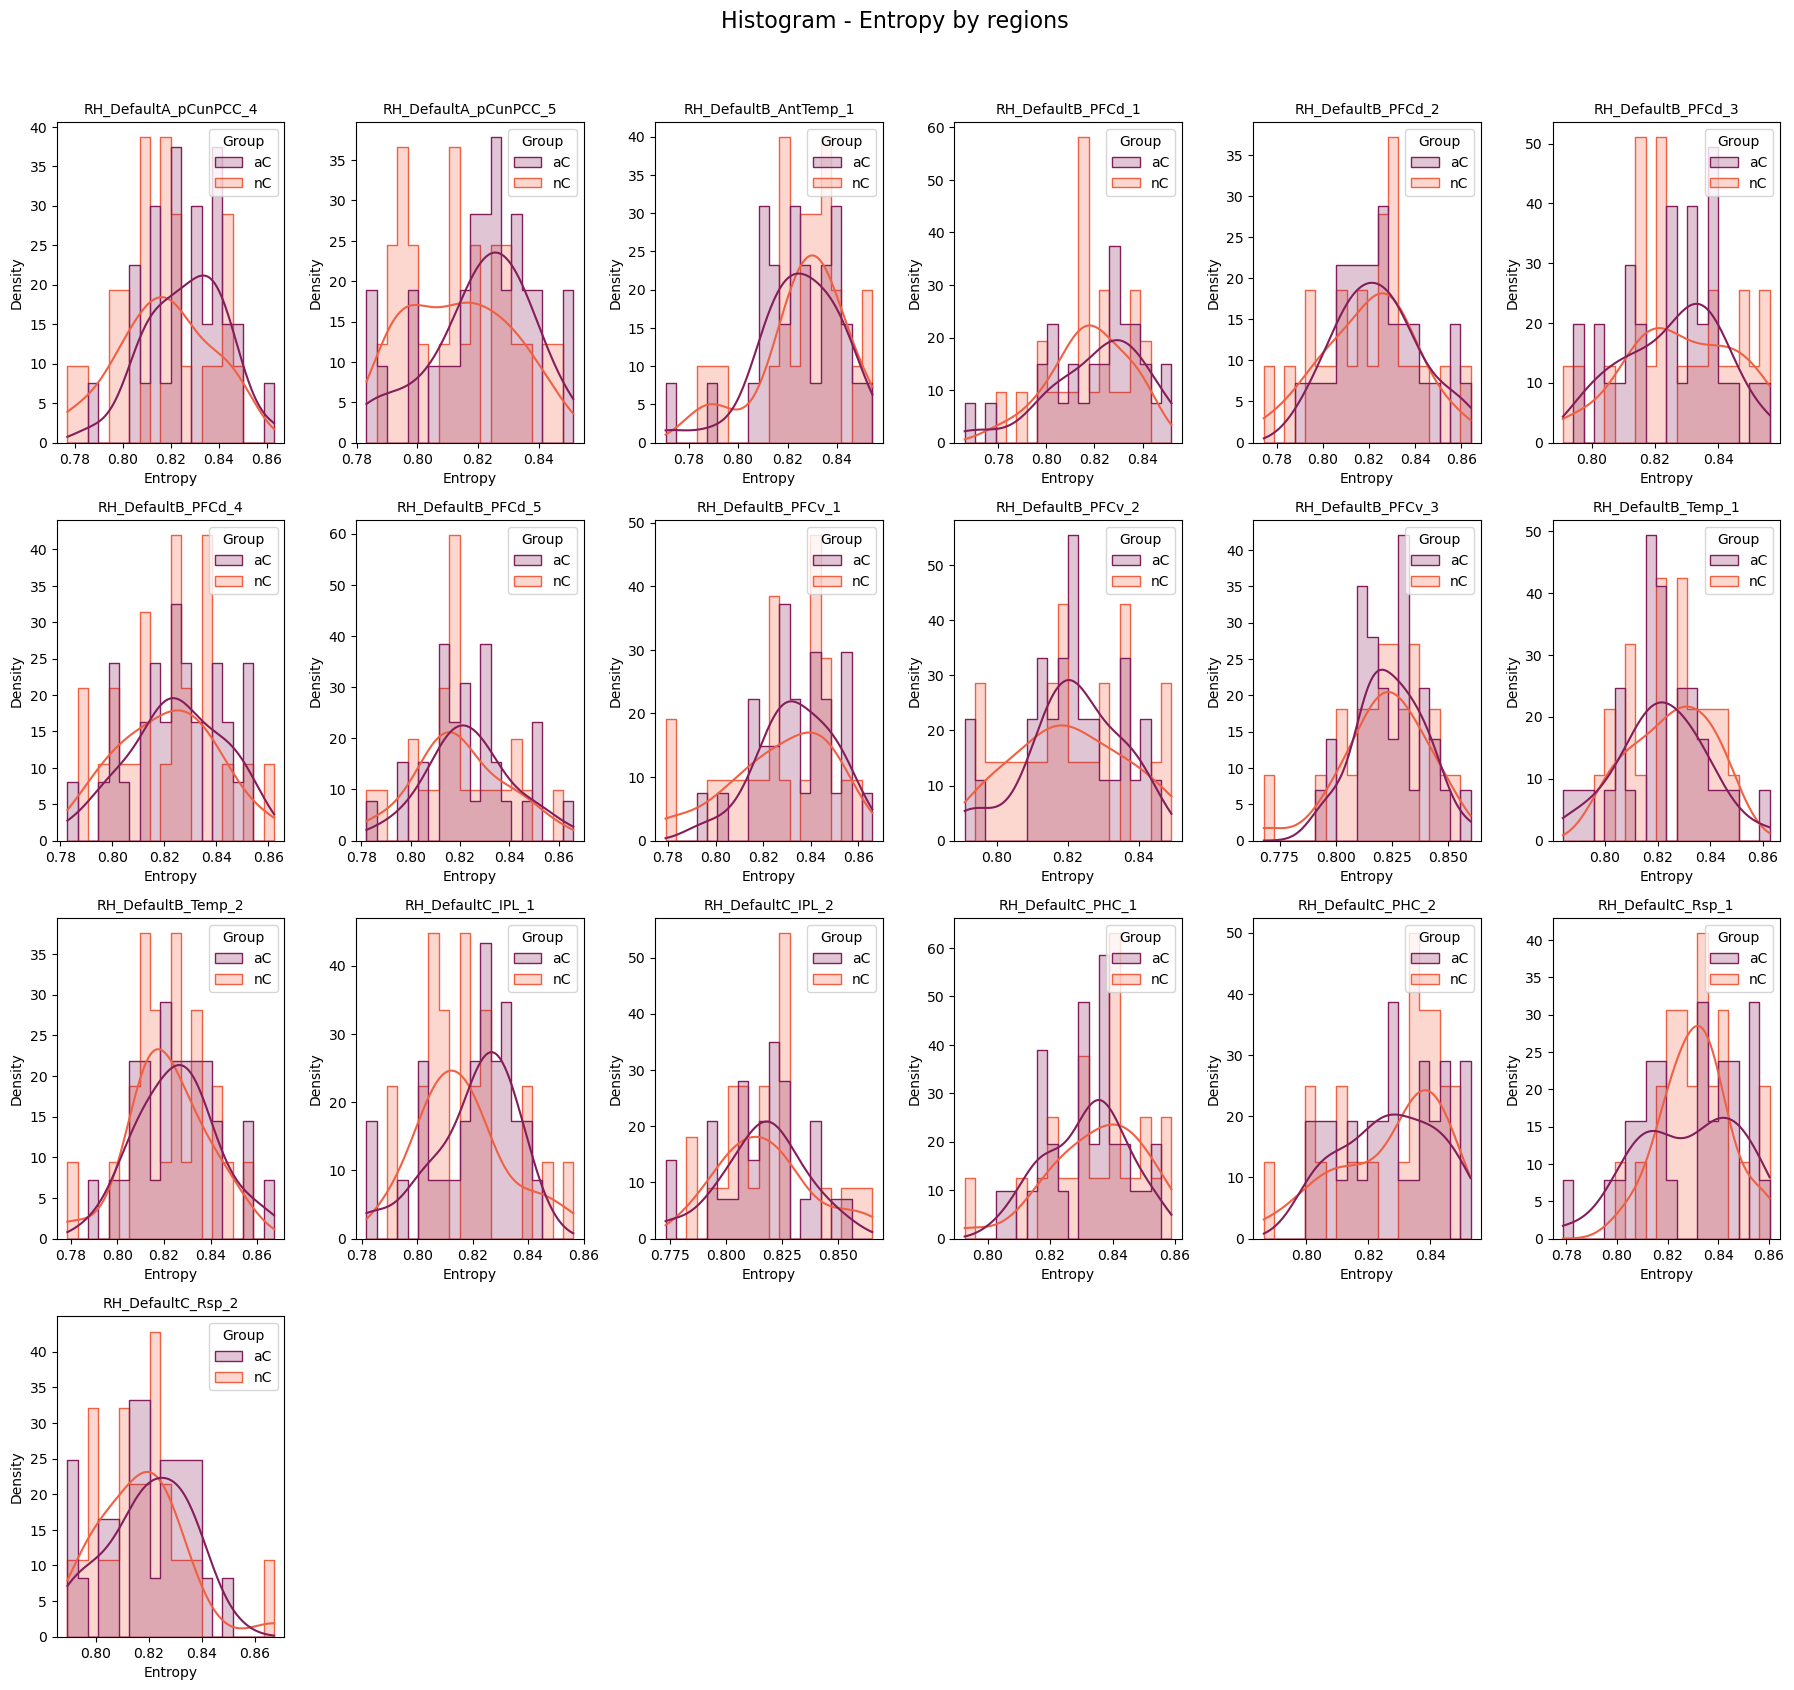

In [598]:
for set_num in range(n_sets):
    start_idx = set_num * n_filas * n_columnas
    end_idx = min((set_num + 1) * n_filas * n_columnas, n_regiones)
    regiones_set = columnas_entropia[start_idx:end_idx]

    fig, axes = plt.subplots(n_filas, n_columnas, figsize=(18, 4 * n_filas))
    fig.suptitle(f"Histogram - Entropy by regions", fontsize=16, y=1.02)
    axes = axes.flatten()

    for i, region in enumerate(regiones_set):
        sns.histplot(data=entropy, x=region, hue="Group", kde=True, bins=20,
                     ax=axes[i], palette="rocket", element="step", stat="density", common_norm=False)
        
        axes[i].set_title(f"{region}", fontsize=10)
        axes[i].set_xlabel("Entropy")
        axes[i].set_ylabel("Density")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

In [564]:
columnas_entropia = entropy.select_dtypes(include='number').columns
estadisticas = entropy.groupby("Group")[columnas_entropia].agg(['mean', 'std'])
estadisticas.head()

LH_DefaultA_IPL_1           LH_DefaultA_IPL_2            \
                   mean       std              mean       std   
Group                                                           
aC             0.814880  0.017094          0.815392  0.019028   
nC             0.815333  0.023551          0.814119  0.018111   

      LH_DefaultA_PFCd_1           LH_DefaultA_PFCd_2            \
                    mean       std               mean       std   
Group                                                             
aC              0.821353  0.019812           0.818975  0.015192   
nC              0.825245  0.019046           0.814876  0.021937   

      LH_DefaultA_PFCd_3            ... RH_DefaultC_IPL_2            \
                    mean       std  ...              mean       std   
Group                               ...                               
aC              0.817473  0.021320  ...          0.816379  0.019065   
nC              0.824333  0.017903  ...          0.817972  0.021430   

      RH_DefaultC_Rsp_1           RH_DefaultC_Rsp_2            \
                   mean       std              mean       std   
Group                                                           
aC             0.828198  0.020453          0.819837  0.015840   
nC             0.831326  0.013484          0.816927  0.016709   

      RH_DefaultC_PHC_1           RH_DefaultC_PHC_2            
                   mean       std              mean       std  
Group                                                          
aC             0.831707  0.012930          0.827372  0.015725  
nC             0.835063  0.015552          0.827378  0.017295  

[2 rows x 158 columns]

<Figure size 1000x1000 with 0 Axes>

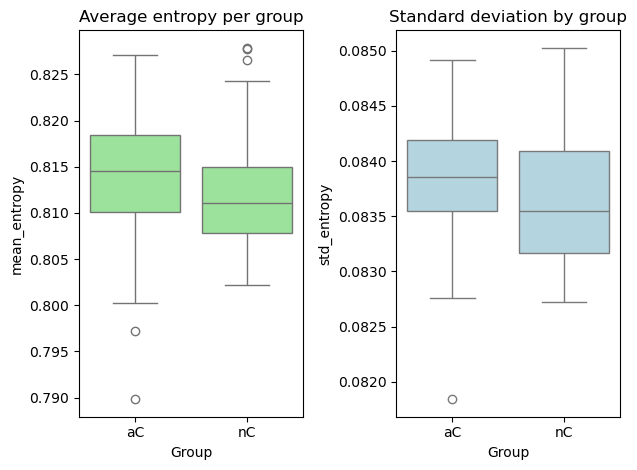

In [605]:
entropy['mean_entropy'] = entropy[columnas_entropia].mean(axis=1)
entropy['std_entropy'] = entropy[columnas_entropia].std(axis=1)

plt.figure(figsize=(10,10))
plt.subplots(1,2)

plt.subplot(1,2,1)
sns.boxplot(data=entropy, x="Group", y="mean_entropy", color = 'lightgreen')
plt.title("Average entropy per group")

plt.subplot(1,2,2)
sns.boxplot(data=entropy, x="Group", y="std_entropy", color = 'lightblue')
plt.title("Standard deviation by group")

plt.tight_layout()